### Initialize library

In [1]:
from limp.utils.gen_utils import ltl2dfa, llm4tl, referent_verification, task_structure_verification, get_spatial_referents
from osg.utils.general_utils import load_data, create_observation_graph
from osg.vlm_library import vlm_library

In [2]:
tmp_fldr=f"results/"
vlm_instance   = vlm_library(vl_model="owl_vit",  seg_model="mobile_sam", tmp_fldr=tmp_fldr) 


Visual language model: owl_vit
-------------------------------------------------
Segmentation model: Mobile SAM
-------------------------------------------------


### Load data

In [3]:
data_path = "../data/sample_data"

observation_data, edge_connectivity, env_pointcloud = load_data(data_path, tmp_fldr)
observations_graph, _, _, _ = create_observation_graph(observation_data,edge_connectivity,tmp_fldr=tmp_fldr)

0 out of 12 || Getting cardinal images for waypoint:balky-cuckoo-DSOhlw+wDw5TKMQhzKNg1Q==
1 out of 12 || Getting cardinal images for waypoint:bended-drum-ZK.nOK2ROH99jbDMGbrG3Q==
2 out of 12 || Getting cardinal images for waypoint:brainy-eel-acD1gEPuOhQgqad45uHuXw==
3 out of 12 || Getting cardinal images for waypoint:frayed-emu-M5JSw0IiYB8xYBwfswR41Q==
4 out of 12 || Getting cardinal images for waypoint:garish-rat-RgSDxBIafXZwgLb2o+h3TA==
5 out of 12 || Getting cardinal images for waypoint:leafy-mayfly-8hSmtSRh9YMd0eyKxJ6Tjw==
6 out of 12 || Getting cardinal images for waypoint:lemony-gibbon-44n7dioWNlkPvLqiIcb2gg==
7 out of 12 || Getting cardinal images for waypoint:lethal-fish-xlr1rhR2yqmfn88mEo7FTw==
8 out of 12 || Getting cardinal images for waypoint:phoney-shark-vJbZmiet4YMbuu.hDi4IOA==
9 out of 12 || Getting cardinal images for waypoint:scared-redbug-AHDnuMg2GzoyJUZUrvMuYA==
10 out of 12 || Getting cardinal images for waypoint:tan-mamba-2DaJ2+ZpP88jbK93.0w4nA==
11 out of 12 || Ge

### Language to  Ltl

In [4]:
#Demo instruction: Bring the green plush toy to the whiteboard in front of it

print(f"\n*************************************************************************\nInstruction Following\n*************************************************************************")
input_lang_instruction = input("Enter the natural language description of the task: ")

in_context_examples = "limp/language/temporal_logic/ltl_datasets/efficient-eng-2-ltl-droneplanning"
in_context_count    = 10
lang2ltl_path       = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2ltl.pkl" 
lang2embedding_path = "limp/language/temporal_logic/embedding_cache/small-droneplanning_lang2embeddings.pkl"

print(f'\nInput instruction: "{input_lang_instruction}"')
print("Running Language Instruction Module ...")

strategy_choice="two_stage_similar_embedding"
# strategy_choice="two_stage_random_embedding"
# strategy_choice="single_stage"

encoding_map, response_ltl, spot_ltl, llm_response_history= llm4tl(input_lang_instruction, in_context_examples, lang2embedding_path, lang2ltl_path, in_context_count, enable_prints=False, strategy=strategy_choice)
original_encoding_map, original_response_ltl, original_spot_ltl, original_llm_response_history = encoding_map, response_ltl, spot_ltl, llm_response_history 

print("Spotify predicate encoding map: ", encoding_map)
print("Response LTL formula: ", response_ltl)
print("Cleaned LTL formula: ", spot_ltl,"\n")

display(spot_ltl)


*************************************************************************
Instruction Following
*************************************************************************

Input instruction: "Bring the green plush toy to the whiteboard in front of it"
Running Language Instruction Module ...
		Model: gpt-4 || Deterministic?: False
		Model: gpt-4 || Deterministic?: False
Spotify predicate encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
Response LTL formula:  F ( A & F ( B & F ( C & F ( D ) ) ) )
Cleaned LTL formula:  F(A & F(B & F(C & FD))) 



spot.formula("F(A & F(B & F(C & FD)))")

### Interactive Symbol Verification

In [5]:
# Referent verification
encoding_map, response_ltl, spot_ltl, llm_response_history  = referent_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Original instruction:  Bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) ) 

*****************************
Referent Verification
*****************************
I extracted this list of relevant objects based on your instruction:
	* whiteboard::isinfrontof(green_plush_toy)
	* green_plush_toy
Does this match your intention? (y/n)


In [6]:
#Task structure verification
encoding_map, response_ltl, spot_ltl, llm_response_history, selected_dfa_path  = task_structure_verification(input_lang_instruction, encoding_map, response_ltl, spot_ltl, llm_response_history, strategy_choice)

Plausible DFA paths to goal:  [[0, 1, 2, 3, 4]] Selected_path:  [0, 1, 2, 3, 4] 

Original instruction:  Bring the green plush toy to the whiteboard in front of it
Last llm ltl response:  F ( near[green_plush_toy] & F ( pick[green_plush_toy] & F ( near[whiteboard::isinfrontof(green_plush_toy)] & F ( release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)] ) ) ) )
Encoded form:  F(A & F(B & F(C & FD))) 

*****************************
Task Structure Verification
*****************************
Based on my understanding here is the sequence of subgoal objectives needed to satisfy the task:
Subgoal_1:
	 Logical Expression: A&!B
	 Decoded Expression: near[green_plush_toy] & ! pick[green_plush_toy]
	 English translation: I should be near the [green_plush_toy] and not have picked up the [green_plush_toy]
Subgoal_2:
	 Logical Expression: B&!C
	 Decoded Expression: pick[green_plush_toy] & ! near[whiteboard::isinfrontof(green_plush_toy)]
	 English translation: I should have picked up the 

In [7]:
# Visualize original and verified results
print("*****************************************\nOriginal Results\n*****************************************")
print("Original encoded formula: ",original_spot_ltl)
print("Original encoding map: ",original_encoding_map)
print("*****************************************\nAfter Verification\n*****************************************")
print("Verified encoded formula: ",spot_ltl)
print("Verified encoding map: ",encoding_map)

*****************************************
Original Results
*****************************************
Original encoded formula:  F(A & F(B & F(C & FD)))
Original encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
*****************************************
After Verification
*****************************************
Verified encoded formula:  F(A & F(B & F(C & FD)))
Verified encoding map:  {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}


### Construct task dfa from ltl

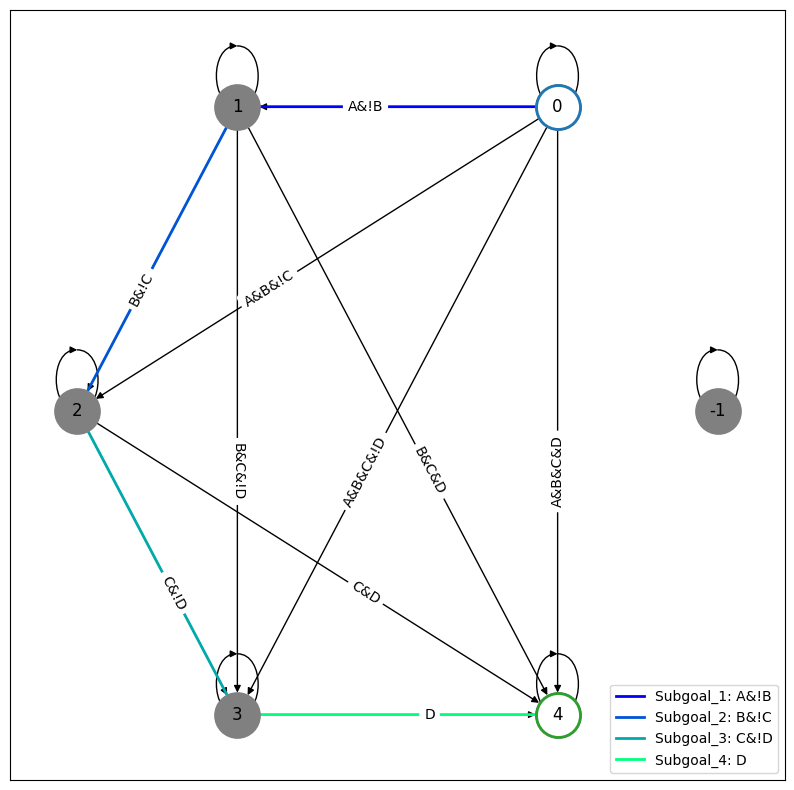

********************************
Task: F(A & F(B & F(C & FD)))
Symbolic maping: {'A': 'near[green_plush_toy]', 'B': 'pick[green_plush_toy]', 'C': 'near[whiteboard::isinfrontof(green_plush_toy)]', 'D': 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'}
********************************
Task Dfa Details
********************************
Initial_state    : 0
Accepting_states :[4]
Ltl2state        :{'False': -1, ('until', 'True', ('and', 'A', ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))))): 0, ('until', 'True', ('and', 'B', ('until', 'True', ('and', 'C', ('until', 'True', 'D'))))): 1, ('until', 'True', ('and', 'C', ('until', 'True', 'D'))): 2, ('until', 'True', 'D'): 3, 'True': 4}
DFA Transitions:
	 Edge: (0, 0, '!A')
	 Edge: (0, 1, 'A&!B')
	 Edge: (0, 2, 'A&B&!C')
	 Edge: (0, 3, 'A&B&C&!D')
	 Edge: (0, 4, 'A&B&C&D')
	 Edge: (1, 1, '!B')
	 Edge: (1, 2, 'B&!C')
	 Edge: (1, 3, 'B&C&!D')
	 Edge: (1, 4, 'B&C&D')
	 Edge: (2, 2, '!C')
	 

In [8]:
#constructing task dfa from ltl formula
task_dfa, dfa_graph = ltl2dfa(encoding_map,spot_ltl, visualize_details=True, show_diagram=True, show_labels=True, path=selected_dfa_path)

### Ground referents and filter instances via spatial constraints

In [9]:
## Extract spatial information
referent_spatial_details = get_spatial_referents(encoding_map)
print("referent_spatial_details: ",referent_spatial_details,"\n")

## Spatial grounding
relevant_element_details = vlm_instance.spatial_grounding(observations_graph, referent_spatial_details, visualize=True, use_segmentation=True, multiprocessing=True, workers=3)

print("Referents after spatial constraint filtering:",len(relevant_element_details))
#for all relevant elements print their ids
print(f"\nFiltered elements \n",[element['mask_id'] for element in relevant_element_details])

referent_spatial_details:  {'whiteboard': ['isinfrontof(green_plush_toy)'], 'green_plush_toy': []} 

Propositions to ground: ['whiteboard', 'green_plush_toy']
--------------------------------------------------------------------------
 Running: VLM Detections || Datanode count: 12 || workers: 3 || workers_after_chunking: 3
--------------------------------------------------------------------------


*************************************************
Begin Spatial Grounding
-------------------------------------------------

Current Element whiteboard_0a_0 || Type: whiteboard || Spatial Details: ['isinfrontof(green_plush_toy)']
    Checking Descriptor: isinfrontof(green_plush_toy)  || Comparative referents: ['green_plush_toy']
        'whiteboard_0a_0' is in front of 'green_plush_toy_2c_1': False
    Element whiteboard_0a_0 || Completed spatial checks: {'isinfrontof(green_plush_toy)': False}

Current Element whiteboard_0b_0 || Type: whiteboard || Spatial Details: ['isinfrontof(green_plush_t

##### Select Robot Start Point in Map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


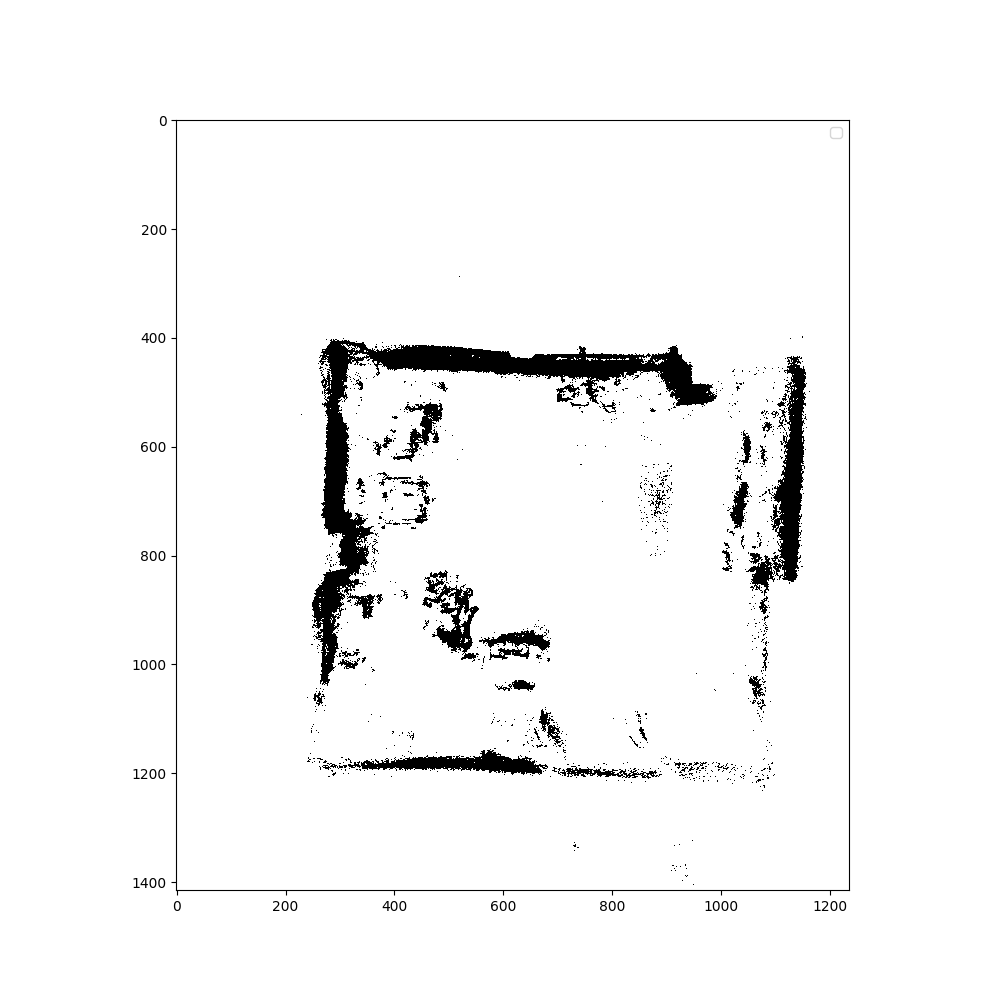

Coordinates: x=965, y=666 || formated: [666, 965]


In [10]:
from limp.planner.multi_level_planner import generate_obstacle_map
from limp.utils.fmt_utils import plot_map_with_points
%matplotlib widget

resolution = 0.01
h_min_bottom = -3
h_max_top = 1
obstacle_map, _, map_min_bound, map_max_bound = generate_obstacle_map(env_pointcloud, None, resolution, h_min_bottom,  h_max_top)

## Visually getting start point from map
clicked_points = plot_map_with_points(obstacle_map)

### Progressive motion planning

*************************************************
Starting Bi-level Planner
-------------------------------------------------
Obtaining predicate satisfying referent positions ...
-------------------------------------------------
Instruction predicates: ['near[green_plush_toy]', 'pick[green_plush_toy]', 'near[whiteboard::isinfrontof(green_plush_toy)]', 'release[green_plush_toy,whiteboard::isinfrontof(green_plush_toy)]'] 

Instruction predicate 1 of 4 
	Encoded Key: A || Predicate: near[green_plush_toy]                             || Predicate Action: near     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of these elements satisfy constraint: []
	Satisfying Elements: ['green_plush_toy_2c_1']
Instruction predicate 2 of 4 
	Encoded Key: B || Predicate: pick[green_plush_toy]                             || Predicate Action: pick     || Arguments: green_plush_toy
	There are 1 element(s) with 'green_plush_toy' label
		Checking if any of t

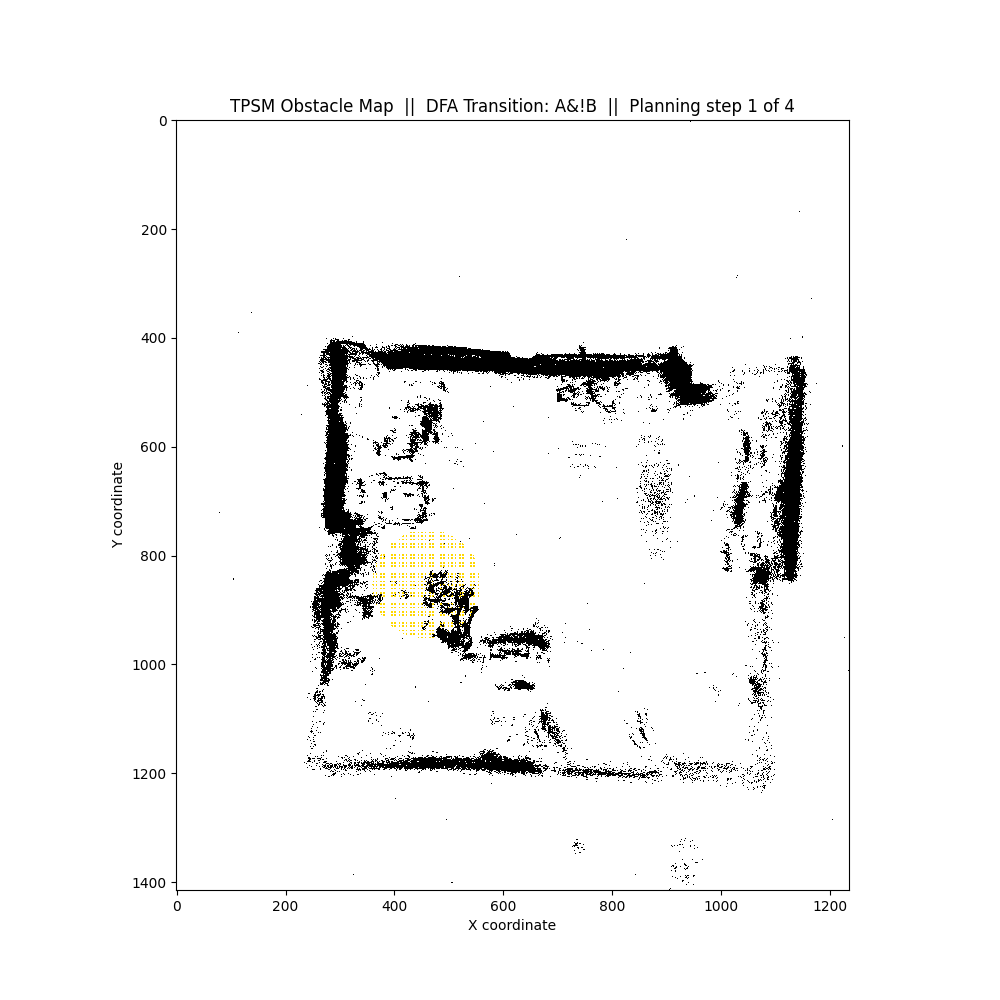

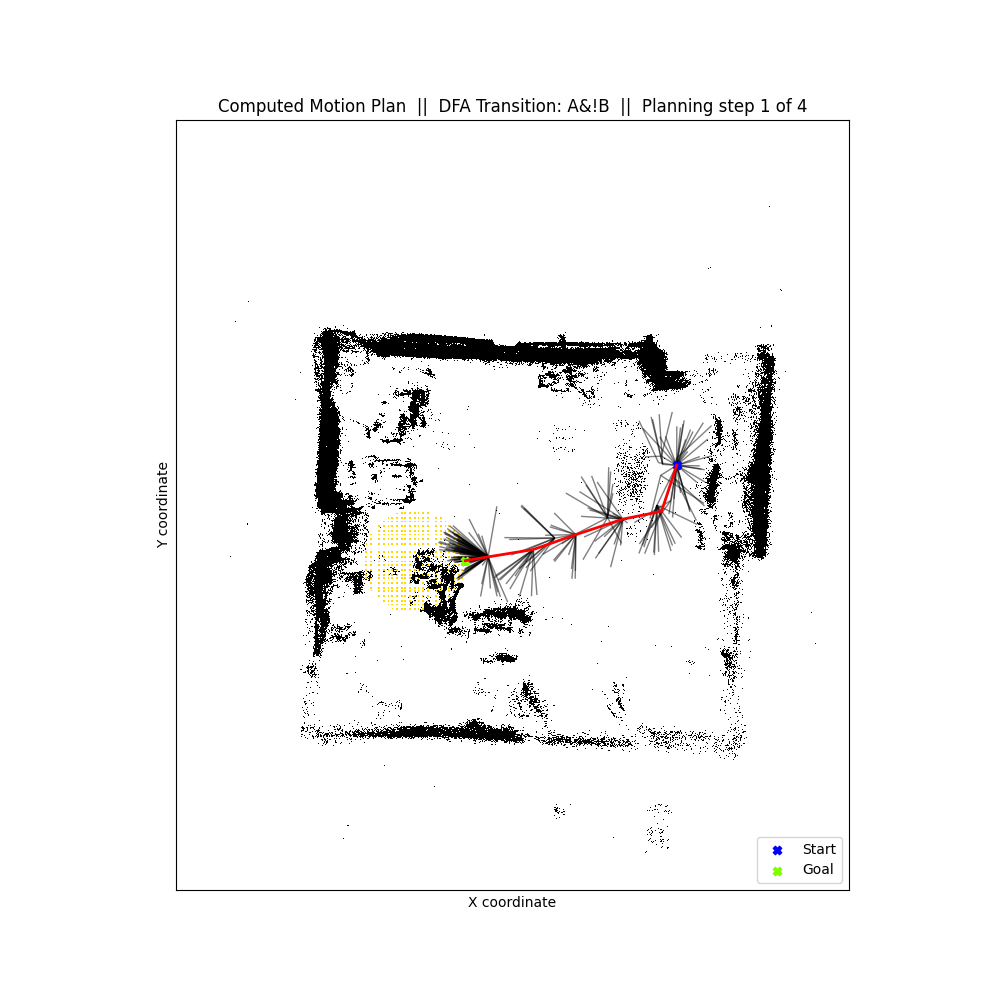

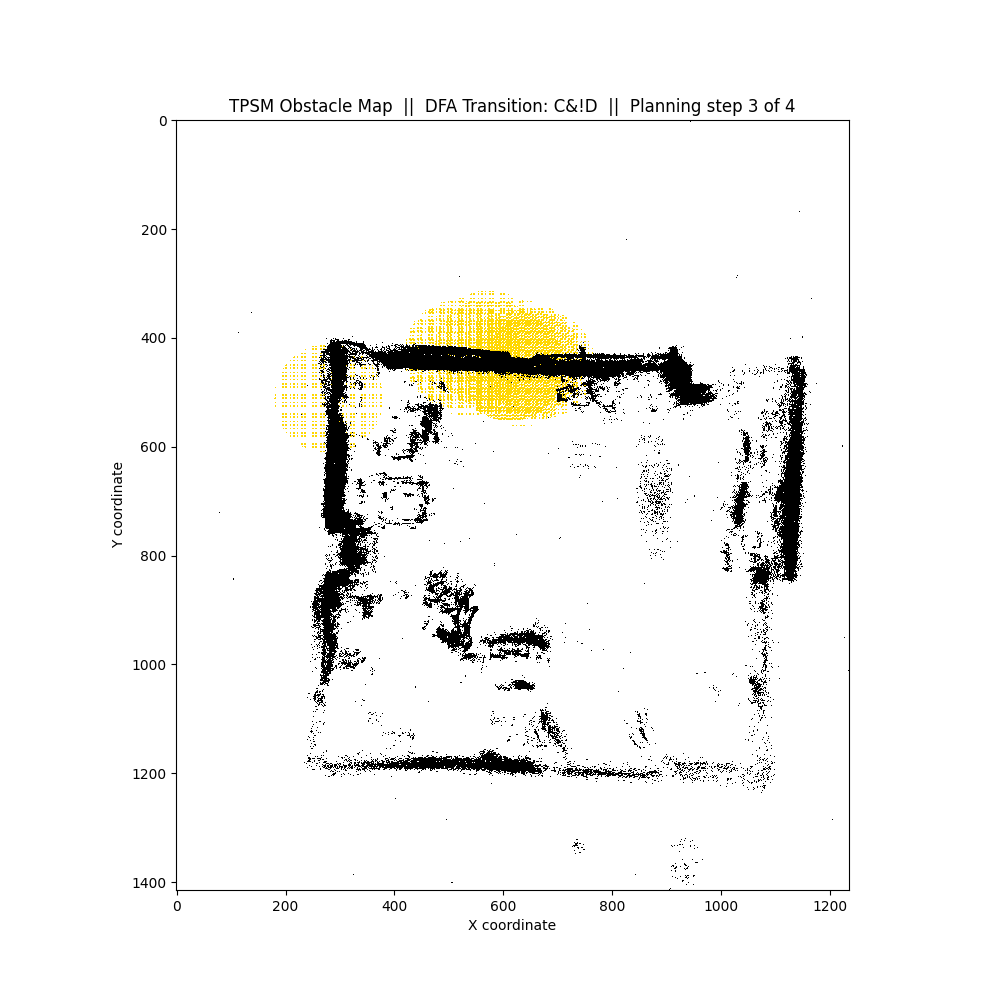

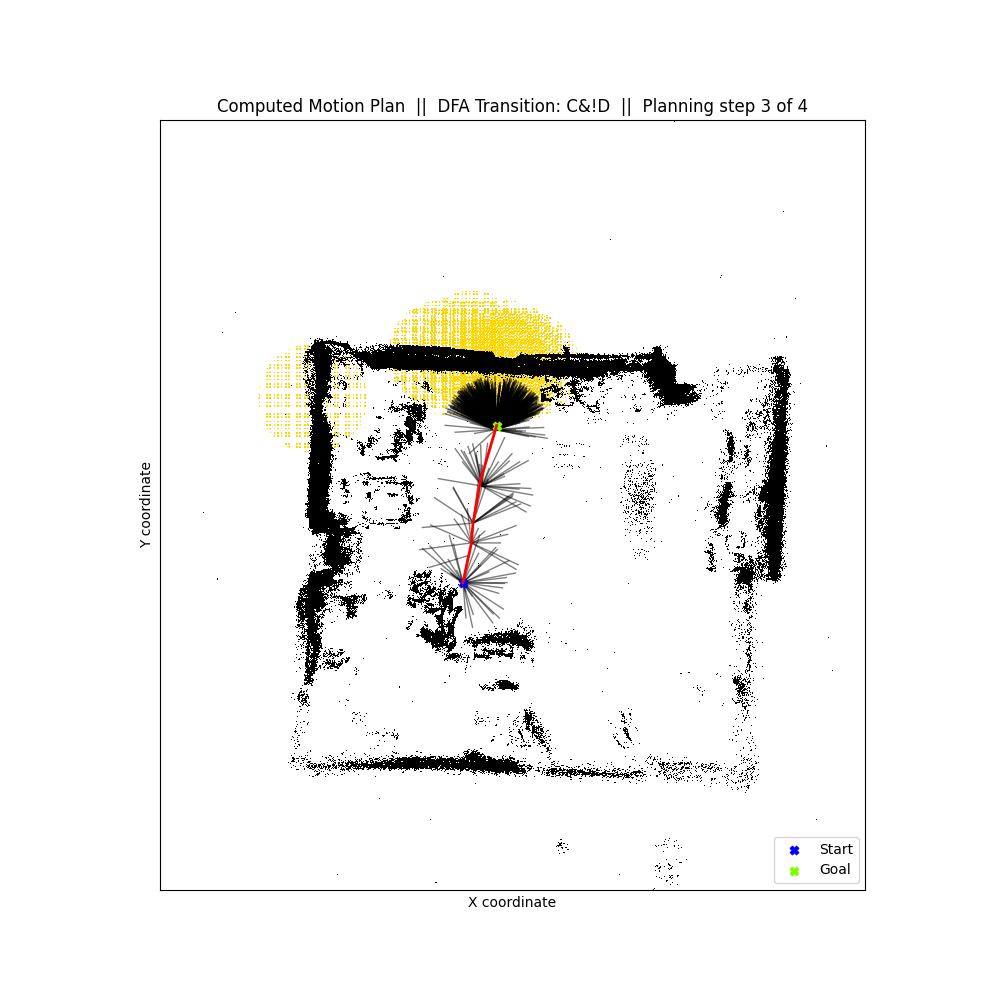

In [11]:
from limp.planner.multi_level_planner import progressive_motion_planner

robot_motion_type = "2D"              #determines if planing space is 2D or 3D
z_height_2d=0                         #height of 2D planning space
      
step_factor=40                        #determines density of generated visual demarcations of regions of interest. Adjust for denser or sparser points
goal_sampling_percentage=15           #percentage of goal points to sample from the goal region to make exhaustive motion planning tractable
use_heuristic_flag=True               #determines if we use modified version of FMT* with cost to goal heuristic 
visualize_flag=True                   #determines if we visualize the computed motion plan
obstacle_map_resolution = 0.01        #determines the resolution of the obstacle map
filter_h_min_bottom = -3              #height to filter out pointcloud points below this height (meters) [Floor]      
filter_h_max_top= 1                   #height to filter out pointcloud points above this height (meters) [Roof] #see doors: 0.7 || Old value:-0.15
nearness_threshold = 1                #determines the meaning of nearness of planning space demarcation (meters)
start_point = clicked_points[-1]      #robot start location
show_color_bars_flag = False

computed_plan = progressive_motion_planner(start_point, task_dfa, dfa_graph, env_pointcloud, relevant_element_details, encoding_map, nearness_threshold, obstacle_map_resolution, filter_h_min_bottom, filter_h_max_top, robot_motion_type, height_2d=z_height_2d, stepfactor=step_factor, use_heuristic=use_heuristic_flag,visualize=visualize_flag,tmp_fldr=tmp_fldr,goal_sample_percentage=goal_sampling_percentage,show_color_bars=show_color_bars_flag)

### View Task and Motion Plan

In [12]:
computed_plan['world_plan'] 

{'step_1': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51298404, -5.25042416, -0.14695237])},
  'path': array([[ 1.64201609, -0.20125637],
         [ 2.53002143, -0.49307937],
         [ 2.68062263, -1.23872667],
         [ 2.98019386, -2.14864732],
         [ 3.26755182, -2.96921833],
         [ 3.40954411, -3.84167114],
         [ 3.48201609, -4.28125637]])},
 'step_2': {'action': 'pick',
  'chosen_goal_referent': {'id': 'green_plush_toy_2c_1',
   'pos': array([ 3.51298404, -5.25042416, -0.14695237])},
  'action_parameter': 'green_plush_toy',
  'action_parameter_positions': array([{'id': 'green_plush_toy_2c_1', 'pos': array([ 3.51298404, -5.25042416, -0.14695237])}],
        dtype=object)},
 'step_3': {'action': 'navigation',
  'chosen_goal_referent': {'id': 'whiteboard_3c_1',
   'pos': array([-0.38108269, -3.52880712, -0.63956896])},
  'path': array([[ 3.48201609, -4.28125637],
         [ 2.74839715, -4.12389383],
         [ 